# 4. LSTM

3장에서는 Johns Hopkins University에서 제공하는 시계열 데이터를 지도학습용 데이터로 변환하는 과정을 실습했습니다. 이번 장에서는 LSTM을 사용하여 앞으로의 대한민국 코로나 확진자 수를 예측해보는 모델을 구축해보겠습니다.

4.1절과 4.2절에서는 대한민국 코로나 누적 확진자 수 데이터를 불러온 후, 데이터를 훈련용, 검증용, 시험용 데이터로 나누어 보겠습니다. 4.3절에서는 LSTM 모델을 정의하고 4.4절에서는 정의한 모델을 학습시켜 보겠습니다. 마지막으로 코로나 확진자 수에 대한 예측값을 확인해보겠습니다.

우선 기본적인 모듈들을 import 해줍니다.

`%matplotlib inline`은 notebook을 실행한 브라우저에서 바로 그림을 볼 수 있게 해주는 것, `%config InlineBackend.figure_format='retina'`는 그래프의 해상도를 높여줍니다.






In [3]:
!pip install tqdm

In [4]:
import torch
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

## 4.1 데이터 다운로드


모델링 실습을 위해 대한민국 코로나 누적 확진자 
데이터를 불러오겠습니다. 2.1절에 나온 코드를 활용하겠습니다. 

In [5]:
!git clone https://github.com/Pseudo-Lab/Tutorial-Book-Utils
!python Tutorial-Book-Utils/PL_data_loader.py --data COVIDTimeSeries
!unzip -q COVIDTimeSeries.zip

fatal: destination path 'Tutorial-Book-Utils' already exists and is not an empty directory.


COVIDTimeSeries.zip is done!


'unzip'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.


## 4.2 데이터 전처리

3장에서 실습한 코드를 활용해 시계열 데이터를 지도학습용 데이터로 변형한 후 학습용, 검증용, 시험용 데이터로 분리하겠습니다. 그리고 훈련용 데이터의 통계량을 활용해 스케일링을 진행하겠습니다. 

In [6]:
#대한민국 데이터만 추출 후 일자별 확진자 수로 변환
confirmed = pd.read_csv('time_series_covid19_confirmed_global.csv')
confirmed[confirmed['Country/Region']=='Korea, South']
korea = confirmed[confirmed['Country/Region']=='Korea, South'].iloc[:,4:].T
korea.index = pd.to_datetime(korea.index)
daily_cases = korea.diff().fillna(korea.iloc[0]).astype('int')


def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length):
        x = data.iloc[i:(i+seq_length)]
        y = data.iloc[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

#지도학습용 데이터로 변환
seq_length = 5
X, y = create_sequences(daily_cases, seq_length)

#학습용, 검증용, 시험용으로 분리
train_size = int(327 * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+33], y[train_size:train_size+33]
X_test, y_test = X[train_size+33:], y[train_size+33:]

MIN = X_train.min()
MAX = X_train.max()

def MinMaxScale(array, min, max):

    return (array - min) / (max - min)

#MinMax 스케일링
X_train = MinMaxScale(X_train, MIN, MAX)
y_train = MinMaxScale(y_train, MIN, MAX)
X_val = MinMaxScale(X_val, MIN, MAX)
y_val = MinMaxScale(y_val, MIN, MAX)
X_test = MinMaxScale(X_test, MIN, MAX)
y_test = MinMaxScale(y_test, MIN, MAX)

#Tensor 형태로 변환
def make_Tensor(array):
    return torch.from_numpy(array).float()

X_train = make_Tensor(X_train)
y_train = make_Tensor(y_train)
X_val = make_Tensor(X_val)
y_val = make_Tensor(y_val)
X_test = make_Tensor(X_test)
y_test = make_Tensor(y_test)

In [7]:
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

torch.Size([261, 5, 1]) torch.Size([33, 5, 1]) torch.Size([33, 5, 1])
torch.Size([261, 1]) torch.Size([33, 1]) torch.Size([33, 1])


## 4.3 LSTM 모델 정의

LSTM 모델을 생성해보겠습니다. `CovidPredictor` 클래스는 기본 변수, layer를 초기화 해주는 생성자, 학습 초기화를 위한 `reset_hidden_state` 함수, 그리고 예측을 위한 `forward` 함수로 구성돼 있습니다.

In [8]:
class CovidPredictor(nn.Module):
    def __init__(self, n_features, n_hidden, seq_len, n_layers):
        super(CovidPredictor, self).__init__()
        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=n_hidden,
            num_layers=n_layers
        )
        self.linear = nn.Linear(in_features=n_hidden, out_features=1)
    def reset_hidden_state(self):
        self.hidden = (
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
        )
    def forward(self, sequences):
        lstm_out, self.hidden = self.lstm(
            sequences.view(len(sequences), self.seq_len, -1),
            self.hidden
        )
        last_time_step = lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
        y_pred = self.linear(last_time_step)
        return y_pred

## 4.4 학습

4.3절에서 정의한 `CovidPredictor` 클래스를 학습시키기 위해 `train_model` 함수를 정의합니다. 학습용 데이터와 검증용 데이터를 입력으로 받으며, `num_epochs`는 학습시킬 epoch 횟수를 의미합니다. `verbose`는 epoch을 `verbose`번째 마다 출력한다는 뜻입니다. `patience`는 검증용 손실값(validation loss)을 `patience`번째 epoch마다 `patience`만큼의 이전 손실값과 비교해 줄어들지 않으면 학습을 종료 시킬 때 사용하는 인자입니다. PyTorch에서는 `hidden_state`를 보존하기 때문에 새로운 시퀀스가 입력될 때마다 `hidden_state`를 초기화 시켜야 이전 시퀀스의 `hidden_state`로 부터 영향을 받지 않습니다. 


In [9]:
def train_model(model, train_data, train_labels, val_data=None, val_labels=None, num_epochs=100, verbose = 10, patience = 10):
    loss_fn = torch.nn.L1Loss() #
    optimiser = torch.optim.Adam(model.parameters(), lr=0.001)
    train_hist = []
    val_hist = []
    for t in range(num_epochs):

        epoch_loss = 0

        for idx, seq in enumerate(train_data): 

            model.reset_hidden_state() # seq 별 hidden state reset

            # train loss
            seq = torch.unsqueeze(seq, 0)
            y_pred = model(seq)
            loss = loss_fn(y_pred[0].float(), train_labels[idx]) # 1개의 step에 대한 loss

            # update weights
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()

            epoch_loss += loss.item()

        train_hist.append(epoch_loss / len(train_data))

        if val_data is not None:

            with torch.no_grad():

                val_loss = 0

                for val_idx, val_seq in enumerate(val_data):

                    model.reset_hidden_state() # seq 별로 hidden state 초기화 

                    val_seq = torch.unsqueeze(val_seq, 0)
                    y_val_pred = model(val_seq)
                    val_step_loss = loss_fn(y_val_pred[0].float(), val_labels[val_idx])

                    val_loss += val_step_loss
                
            val_hist.append(val_loss / len(val_data)) # val hist에 추가

            ## verbose 번째 마다 loss 출력 
            if t % verbose == 0:
                print(f'Epoch {t} train loss: {epoch_loss / len(train_data)} val loss: {val_loss / len(val_data)}')

            ## patience 번째 마다 early stopping 여부 확인
            if (t % patience == 0) & (t != 0):
                
                ## loss가 커졌다면 early stop
                if val_hist[t - patience] < val_hist[t] :

                    print('\n Early Stopping')

                    break

        elif t % verbose == 0:
            print(f'Epoch {t} train loss: {epoch_loss / len(train_data)}')

            
    return model, train_hist, val_hist

In [10]:
model = CovidPredictor(
    n_features=1,
    n_hidden=4,
    seq_len=seq_length,
    n_layers=1
)
model, train_hist, val_hist = train_model(
    model,
    X_train,
    y_train,
    X_val,
    y_val,
    num_epochs=100,
    verbose=10,
    patience=50
)

Epoch 0 train loss: 0.08467356757871036 val loss: 0.0472203865647316
Epoch 10 train loss: 0.03268902623397923 val loss: 0.03414301201701164
Epoch 20 train loss: 0.03255926622113506 val loss: 0.03243739902973175
Epoch 30 train loss: 0.03268276179348515 val loss: 0.03306415304541588
Epoch 40 train loss: 0.03259286563219039 val loss: 0.03251414746046066
Epoch 50 train loss: 0.03231643823375105 val loss: 0.03300009295344353
Epoch 60 train loss: 0.03259847939489017 val loss: 0.032665643841028214
Epoch 70 train loss: 0.032208836823880274 val loss: 0.03289766609668732
Epoch 80 train loss: 0.032646661812539474 val loss: 0.032588861882686615
Epoch 90 train loss: 0.03234944240746741 val loss: 0.03221790865063667


`train_hist`와 `val_hist`에 저장된 손실값들을 시각화 해보겠습니다.

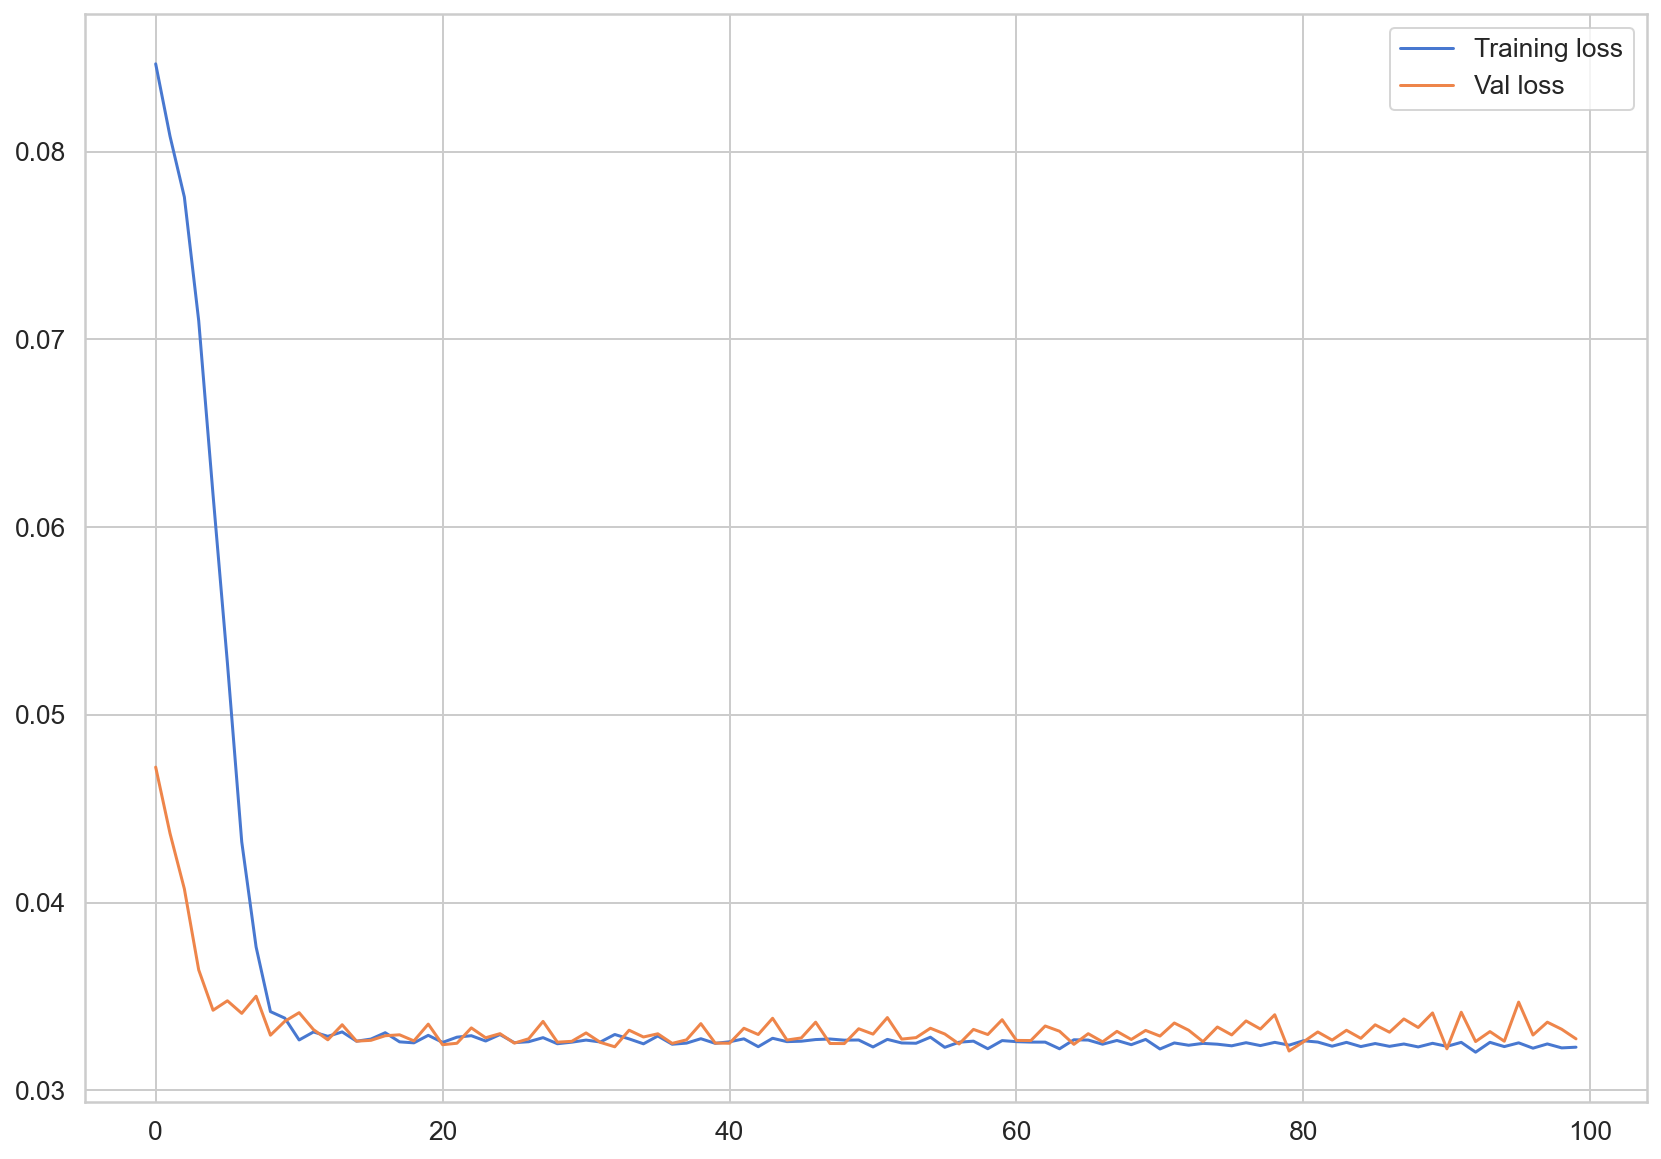

In [11]:
plt.plot(train_hist, label="Training loss")
plt.plot(val_hist, label="Val loss")
plt.legend()

## 4.5 예측

이번 절에서는 구축한 모델을 활용해 새로 들어오는 데이터에 대한 예측을 진행해보겠습니다. 현재 구축된 모델은 $t-5$시점 부터 $t-1$시점까지의 데이터를 활용해 $t$시점의 확진자를 예측합니다. 마찬가지로 실제 관측된 $t-5$부터 $t-1$까지의 새로운 데이터를 입력한다면 $t$시점의 확진자에 대한 예측이 가능할 것이며, 이를 `One-Step`예측이라고 합니다. 과거 데이터를 활용해 한 단위 앞만 예측하는 방법입니다. 

반면 과거 데이터를 활용해 두 단위, 세 단위 등의 여러 단위 앞을 예측하는 것을 `Multi-Step`예측이라고 합니다. `Multi-Step`예측에는 크게 2가지 방법으로 나뉘는데, 앞서 구축한 `One-Step`예측하는 모델을 활용하는 방법과 `seq2seq`구조의 모델을 활용하는 방법이 있습니다. 

첫번째 방법은 `One-Step`예측하는 모델에서 반환한 $t$시점의 예측값 $\hat{t}$을 활용해 $t-4$, $t-3$, $t-2$, $t-1$, $\hat{t}$ 값으로 $t+1$시점의 값을 예측합니다. 이처럼 모델에서 나온 예측값을 다시 모델 입력값으로 넣어 반복적으로 예측할 수 있지만, 예측값의 오차가 누적되어 점차 예측 성능이 떨어지는 현상이 발생합니다. 

두번째 방법은 `seq2seq`구조를 활용해 예측하는 것입니다. 예측하고자 하는 미래 기간 만큼 `decoder` 길이를 설정해서 예측하는 방법입니다. `decoder`네트워크를 통해 추가 정보를 예측값 산출 시 활용할 수 있다는 장점이 있지만 예측 시간 단위가 고정돼야 합니다. 

이번 절에서는 `One-Step`예측 모델을 반복적으로 활용해 `Multi-Step`예측하는 것을 코드로 확인해보겠습니다. 

### 4.5.1 One-Step 예측

우선 앞서 만든 모델에 대한 `One-Step`예측을 진행해 모델 성능을 확인해보겠습니다. 구축된 시험 데이터에 대한 예측을 진행해보겠습니다. 예측할 때도 새로운 시퀀스가 입력될 때 마다 `hidden_state`는 초기화를 해줘야 이전 시퀀스의 `hidden_state`가 반영되지 않습니다. `torch.unsqueeze` 함수를 사용하여 입력 데이터의 차원을 늘려 모델이 예상하는 3차원 형태로 만들어줍니다. 그리고 예측된 데이터 내에 존재하는 스칼라값만 추출하여 `preds` 리스트에 추가합니다.

In [12]:
pred_dataset = X_test

with torch.no_grad():
    preds = []
    for _ in range(len(pred_dataset)):
        model.reset_hidden_state()
        y_test_pred = model(torch.unsqueeze(pred_dataset[_], 0))
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)

모델이 예측한 값과 실제값과 비교를 진행해보겠습니다. `y_test`에 실제값이 저장돼있으며 현재 스케일링된 상태입니다. 원래 스케일로 변환시켜주기 위해서 아래 산식을 활용하겠습니다. MinMax 스케일링을 적용할 때 사용한 산식을 응용하여 원래 값으로 변환하는 산식입니다. 

>$x = x_{scaled} * (x_{max} - x_{min}) + x_{min}$

이번 데이터에서 $x_{min}$은 0이였습니다. 그러므로 원래 스케일로 복구하기 위해선 $x_{max}$만 곱해주면 됩니다. 

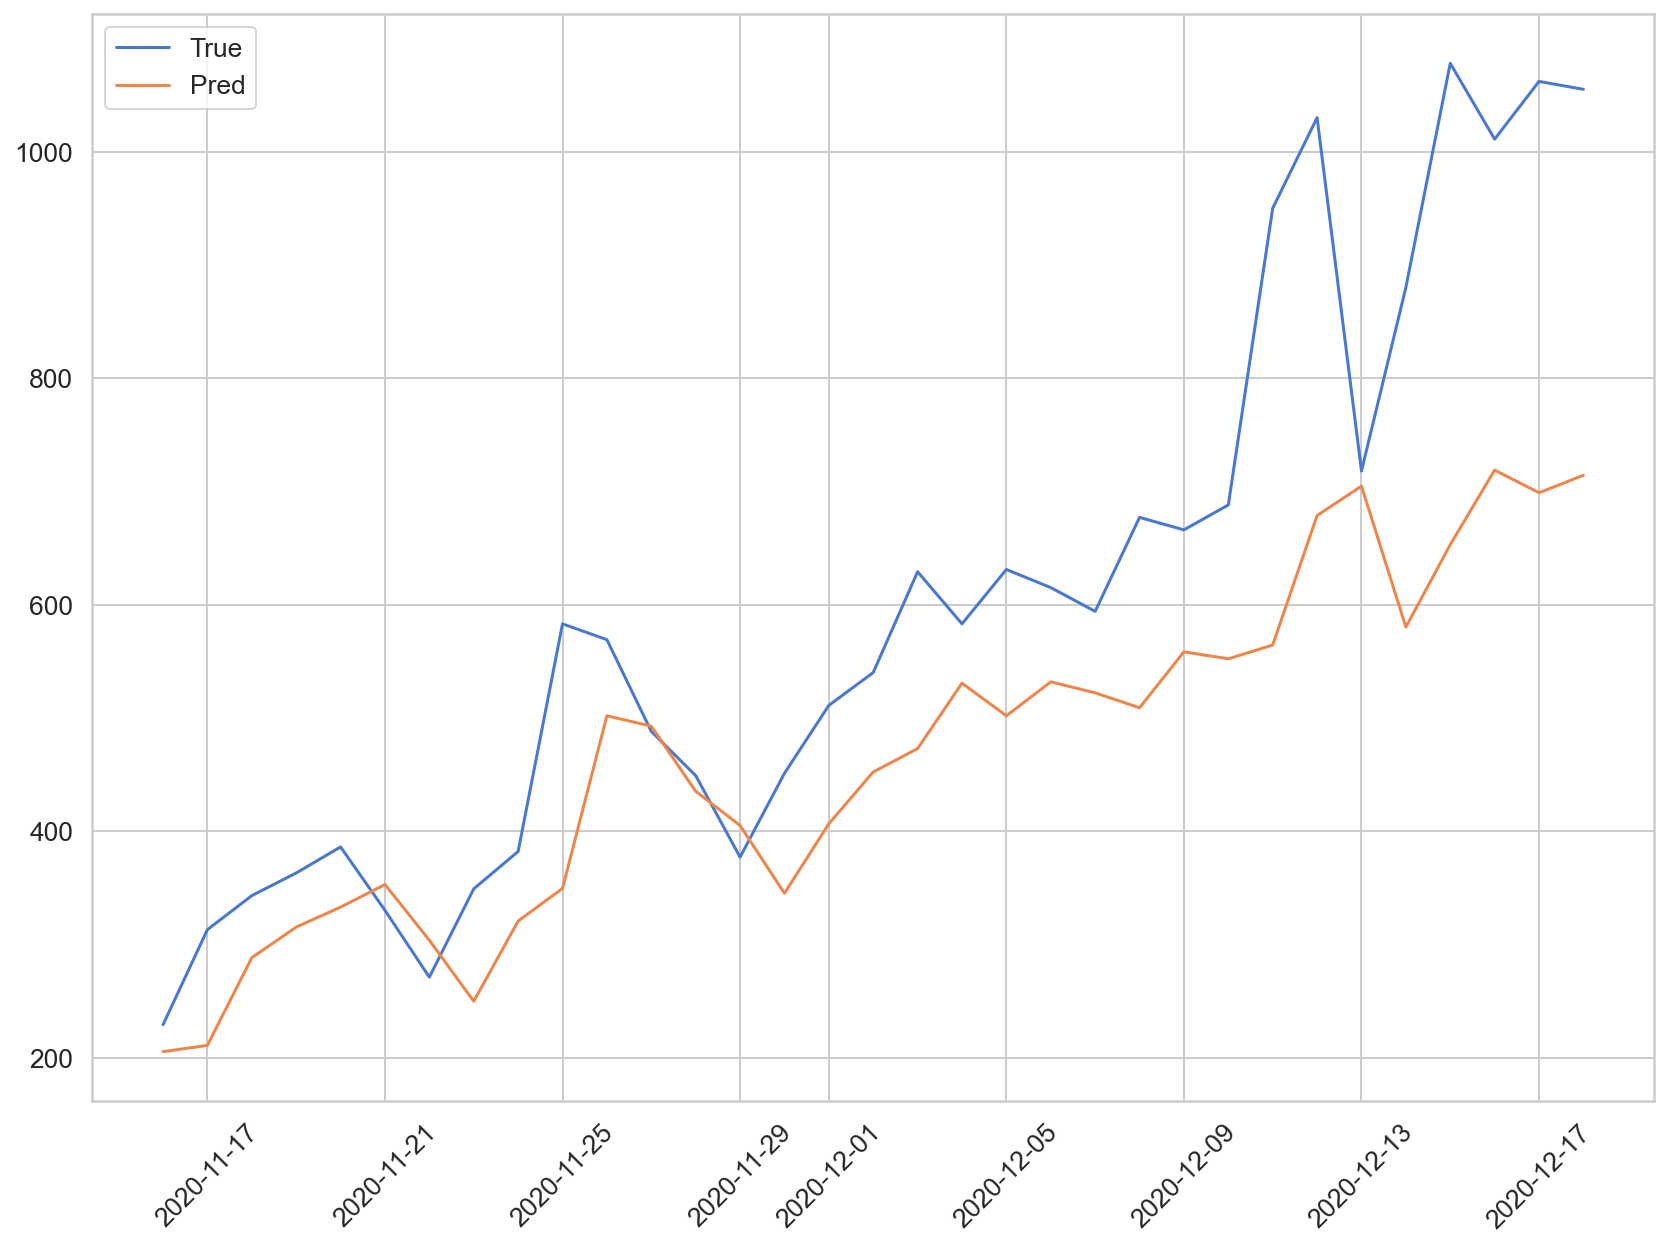

In [13]:
plt.plot(daily_cases.index[-len(y_test):], np.array(y_test) * MAX, label='True')
plt.plot(daily_cases.index[-len(preds):], np.array(preds) * MAX, label='Pred')
plt.xticks(rotation=45)
plt.legend()

파란색 그래프는 시험 데이터의 실제값을 나타내며 주황색 그래프는 예측값을 나타냅니다. 확진자가 상승하는 추세는 모델이 예측하고 있지만 확진자가 급격히 증가하는 구간에 대해서는 예측이 잘 되지 않음을 알 수 있습니다.

예측값의 평균 오차를 구하기 위해 MAE 값을 산출해보겠습니다. 

In [14]:
def MAE(true, pred):
    return np.mean(np.abs(true-pred))

In [15]:
MAE(np.array(y_test)*MAX, np.array(preds)*MAX)

247.31320774003768

시험 데이터에 대한 예측값이 평균적으로 실제값과 약 250명의 차이를 지니고 있다는 것을 알 수 있습니다. 과거 확진자 수 뿐만 아니라 인구 이동 데이터, 인구 통계 데이터 등을 활용한다면 보다 정교한 예측이 가능할 것으로 보입니다. 

### 4.5.2 Multi-Step 예측

`One-Step`예측 모델을 반복적으로 활용해 `Multi-Step`예측을 진행해보겠습니다. 시험 데이터의 첫번째 샘플을 활용해 나온 예측값을 입력 시퀀스에 포함시켜 다음 값을 예측하고, 또 해당 값을 입력 시퀸스에 포함시켜 다음 값을 예측하는 과정을 반복하겠습니다. 

In [16]:
with torch.no_grad():
    test_seq = X_test[:1] # 첫번째 테스트 셋, 3차원
    preds = []
    for _ in range(len(X_test)):
        model.reset_hidden_state()
        y_test_pred = model(test_seq)
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)
        new_seq = test_seq.numpy().flatten()
        new_seq = np.append(new_seq, [pred]) # 시퀀스에 추가 
        new_seq = new_seq[1:] # 추가된 값을 포함하여 seq_length가 5개가 되도록 맞추기 
        test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

앞서 언급한 것처럼 해당 방법은 예측 기간이 길어질수록 오차가 누적되어 모델의 성능을 보장하기 어렵습니다. 아래 그래프로 예측값을 실제값과 비교해 시각화 해보겠습니다.

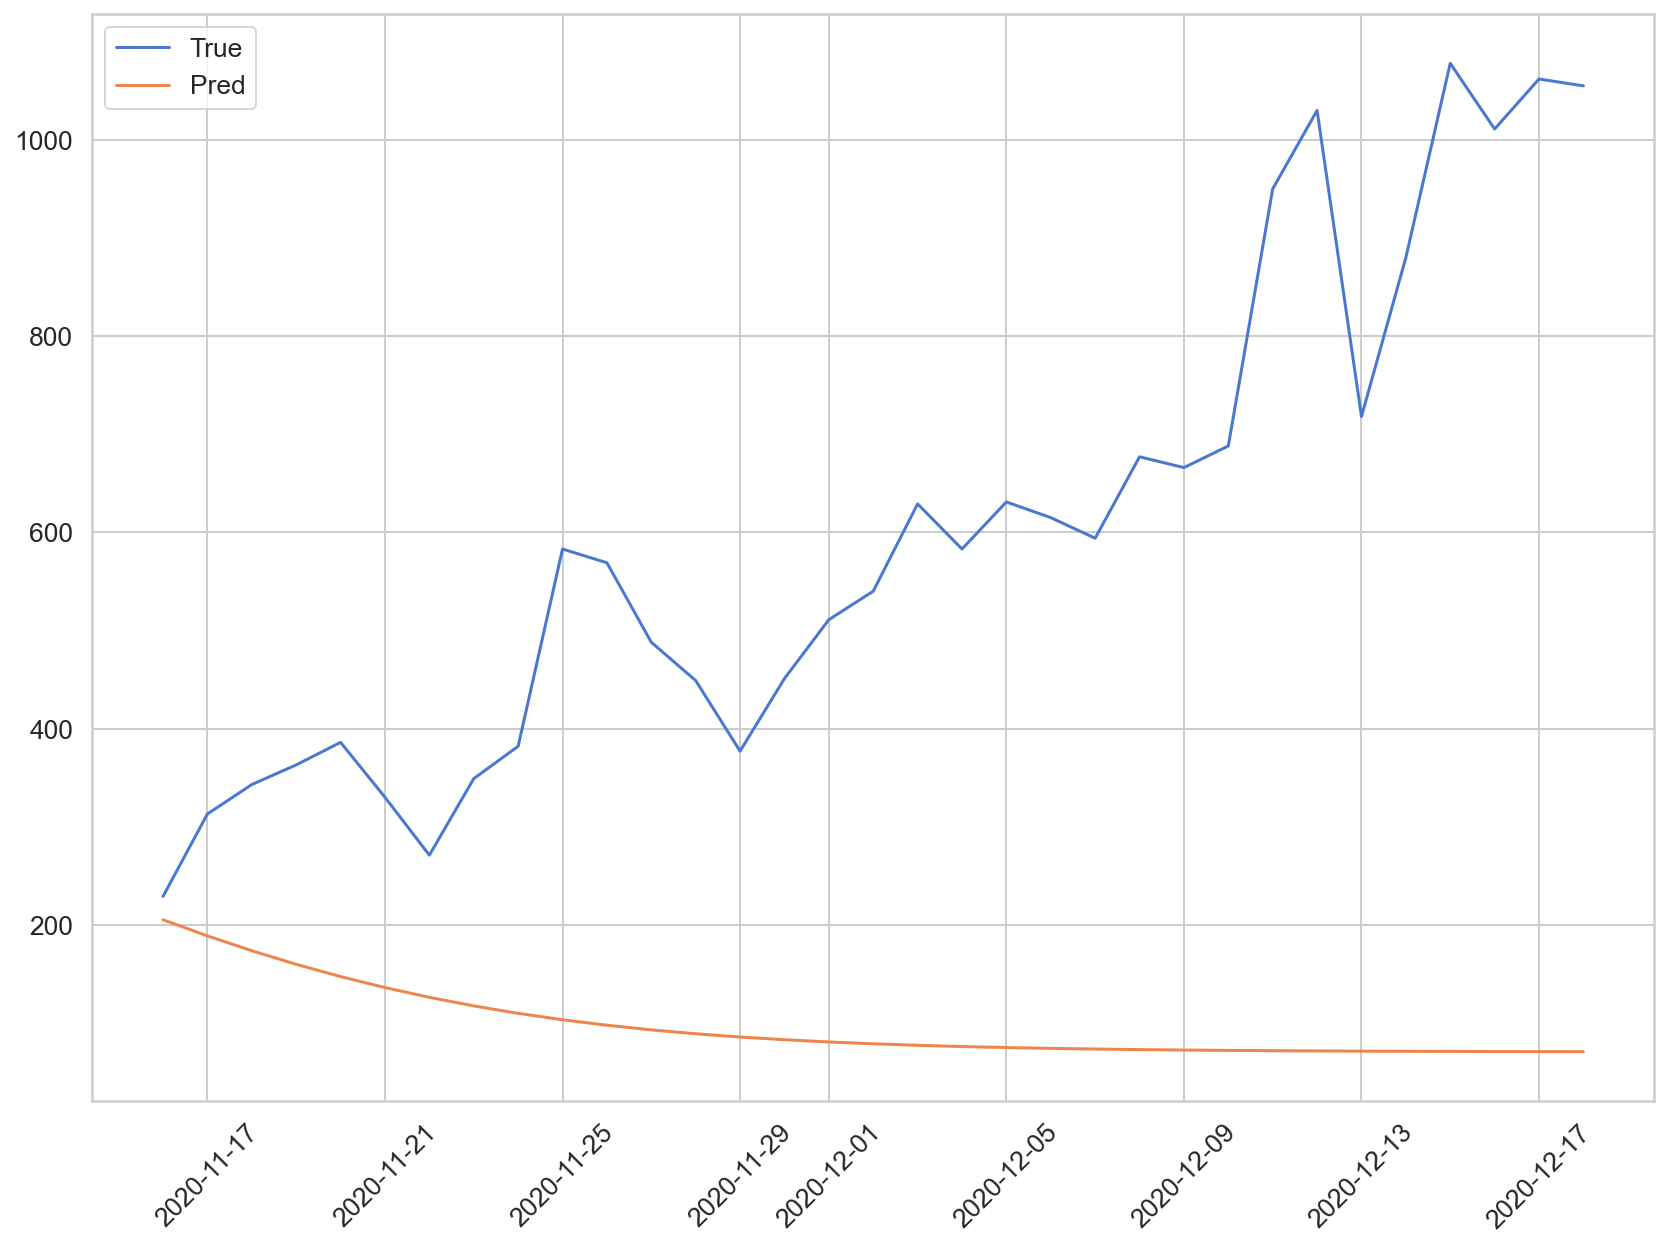

In [17]:
plt.plot(daily_cases.index[-len(y_test):], np.array(y_test) * MAX, label='True')
plt.plot(daily_cases.index[-len(preds):], np.array(preds) * MAX, label='Pred')
plt.xticks(rotation=45)
plt.legend()

지금까지 코로나 확진자 데이터를 활용해 LSTM 모델 구축 실습을 진행했습니다. 다음 장에서는 CNN-LSTM을 시계열 데이터에 적용해보는 실습을 진행하겠습니다. 